## Observations and Insights 

In [1]:
%matplotlib notebook

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import random

from scipy.stats import linregress, pearsonr
from sklearn import datasets

# Set the seed so data is reproducible
random.seed(42)

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_rpt_df = pd.merge(mouse_metadata,study_results,how='outer', on='Mouse ID')

# Display the data table for preview

mouse_rpt_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [3]:
# Checking the number of mice.
num_mice = mouse_rpt_df.drop_duplicates('Mouse ID')['Mouse ID'].count()
print("Total number of mice in study: " + str(num_mice))

Total number of mice in study: 249


In [4]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
mouse_rpt_df['Duplicate'] = mouse_rpt_df.duplicated(['Mouse ID','Timepoint'])
dup_mouse = mouse_rpt_df[mouse_rpt_df['Duplicate']
                          ==True].drop_duplicates(['Mouse ID'])

dup_mouseid = dup_mouse['Mouse ID'].tolist()

print("Mouse ID: " + str(dup_mouseid))
print("Shows up as a duplicate for Mouse ID and Timepoint")

Mouse ID: ['g989']
Shows up as a duplicate for Mouse ID and Timepoint


In [5]:
# Optional: Get all the data for the duplicate mouse ID. 
lsdup_mouse = mouse_rpt_df.loc[mouse_rpt_df['Mouse ID']=='g989']
lsdup_mouse

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Duplicate
908,g989,Propriva,Female,21,26,0,45.000000,0,False
909,g989,Propriva,Female,21,26,0,45.000000,0,True
910,g989,Propriva,Female,21,26,5,48.786801,0,False
911,g989,Propriva,Female,21,26,5,47.570392,0,True
912,g989,Propriva,Female,21,26,10,51.745156,0,False
913,g989,Propriva,Female,21,26,10,49.880528,0,True
914,g989,Propriva,Female,21,26,15,51.325852,1,False
915,g989,Propriva,Female,21,26,15,53.442020,0,True
916,g989,Propriva,Female,21,26,20,55.326122,1,False
917,g989,Propriva,Female,21,26,20,54.657650,1,True


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
cmousend_rpt_df = mouse_rpt_df.loc[mouse_rpt_df['Mouse ID']!='g989']
del cmousend_rpt_df['Duplicate']
cmousend_rpt_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [8]:
# Checking the number of mice in the clean DataFrame.
num_micend = cmousend_rpt_df.drop_duplicates('Mouse ID')['Mouse ID'].count()
print("Total number of mice in clean DataFrame: " + str(num_micend))

Total number of mice in clean DataFrame: 248


## Summary Statistics

In [9]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
treatls = pd.Series(cmousend_rpt_df['Drug Regimen'].unique())

stat_sum = []

for drugs in treatls:
    capo_one = cmousend_rpt_df.loc[cmousend_rpt_df['Drug Regimen'] == drugs]
    c_one = {
        'Drug Regimen':drugs,
        'Tumor Volume-Mean' : capo_one['Tumor Volume (mm3)'].mean(),
        'Tumor Volume-Median' : capo_one['Tumor Volume (mm3)'].median(),
        'Tumor Volume-Variance' : capo_one['Tumor Volume (mm3)'].var(),
        'Tumor Volume-Std Dev' : capo_one['Tumor Volume (mm3)'].std(),
        'Tumor Volume-SEM' : capo_one['Tumor Volume (mm3)'].sem()
    }
    stat_sum.append(c_one)


statsum_df = pd.DataFrame(stat_sum)
statsum2_df = statsum_df.set_index('Drug Regimen')
statsum2_df.style.format("{:.2f}")

# This method is the most straighforward, creating multiple series and putting them all together at the end.


,Tumor Volume-Mean,Tumor Volume-Median,Tumor Volume-Variance,Tumor Volume-Std Dev,Tumor Volume-SEM
Drug Regimen,,,,,
Ramicane,40.22,40.67,23.49,4.85,0.32
Capomulin,40.68,41.56,24.95,4.99,0.33
Infubinol,52.88,51.82,43.13,6.57,0.49
Placebo,54.03,52.29,61.17,7.82,0.58
Ceftamin,52.59,51.78,39.29,6.27,0.47
Stelasyn,54.23,52.43,59.45,7.71,0.57
Zoniferol,53.24,51.82,48.53,6.97,0.52
Ketapril,55.24,53.70,68.55,8.28,0.60
Propriva,52.32,50.45,43.85,6.62,0.54


In [10]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
cal_mean = cmousend_rpt_df.groupby(['Drug Regimen']).mean()['Tumor Volume (mm3)']
cal_median = cmousend_rpt_df.groupby(['Drug Regimen']).median()['Tumor Volume (mm3)']
cal_variance = cmousend_rpt_df.groupby(['Drug Regimen']).var()['Tumor Volume (mm3)']
cal_std_dev = cmousend_rpt_df.groupby(['Drug Regimen']).std()['Tumor Volume (mm3)']
cal_sem = cmousend_rpt_df.groupby(['Drug Regimen']).sem()['Tumor Volume (mm3)']

# This method is the most straighforward, creating multiple series and putting them all together at the end.
summary_statistics = pd.DataFrame({
    'Tumer Volume-Mean':cal_mean,
    'Tumer Volume-Median':cal_median,
    'Tumer Volume-Variance':cal_variance,
    'Tumer Volume-Std Dev':cal_std_dev,
    'Tumer Volume-SEM':cal_sem
})
summary_statistics.style.format('{:.2f}')

,Tumer Volume-Mean,Tumer Volume-Median,Tumer Volume-Variance,Tumer Volume-Std Dev,Tumer Volume-SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.33
Ceftamin,52.59,51.78,39.29,6.27,0.47
Infubinol,52.88,51.82,43.13,6.57,0.49
Ketapril,55.24,53.70,68.55,8.28,0.60
Naftisol,54.33,52.51,66.17,8.13,0.60
Placebo,54.03,52.29,61.17,7.82,0.58
Propriva,52.32,50.45,43.85,6.62,0.54
Ramicane,40.22,40.67,23.49,4.85,0.32
Stelasyn,54.23,52.43,59.45,7.71,0.57


In [11]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method produces everything in a single groupby function
pd.options.display.float_format = '{:.2f}'.format
cmousend_rpt_df.groupby(['Drug Regimen']).agg({'Tumor Volume (mm3)': ['mean','median','var','std','sem']})

Tumor Volume (mm3)                       
                           mean median   var  std  sem
Drug Regimen                                          
Capomulin                 40.68  41.56 24.95 4.99 0.33
Ceftamin                  52.59  51.78 39.29 6.27 0.47
Infubinol                 52.88  51.82 43.13 6.57 0.49
Ketapril                  55.24  53.70 68.55 8.28 0.60
Naftisol                  54.33  52.51 66.17 8.13 0.60
Placebo                   54.03  52.29 61.17 7.82 0.58
Propriva                  52.32  50.45 43.85 6.62 0.54
Ramicane                  40.22  40.67 23.49 4.85 0.32
Stelasyn                  54.23  52.43 59.45 7.71 0.57
Zoniferol                 53.24  51.82 48.53 6.97 0.52

## Bar and Pie Charts

<IPython.core.display.Javascript object>


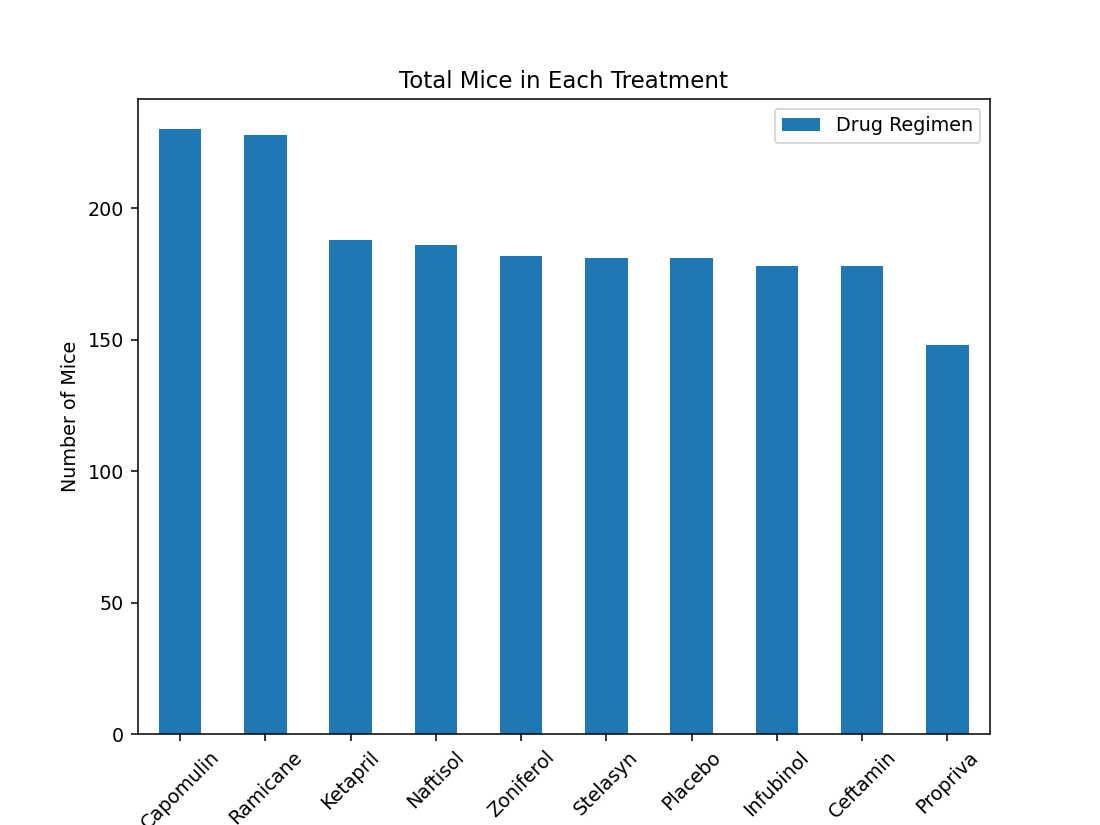

In [11]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas. 
treat_ct = cmousend_rpt_df['Drug Regimen'].value_counts()

treat_ct.plot(kind='bar', rot=45, figsize=(8,6),
                           title='Total Mice in Each Treatment',
                           ylabel='Number of Mice',xlabel='Drug Regimen', label='Drug Regimen')
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


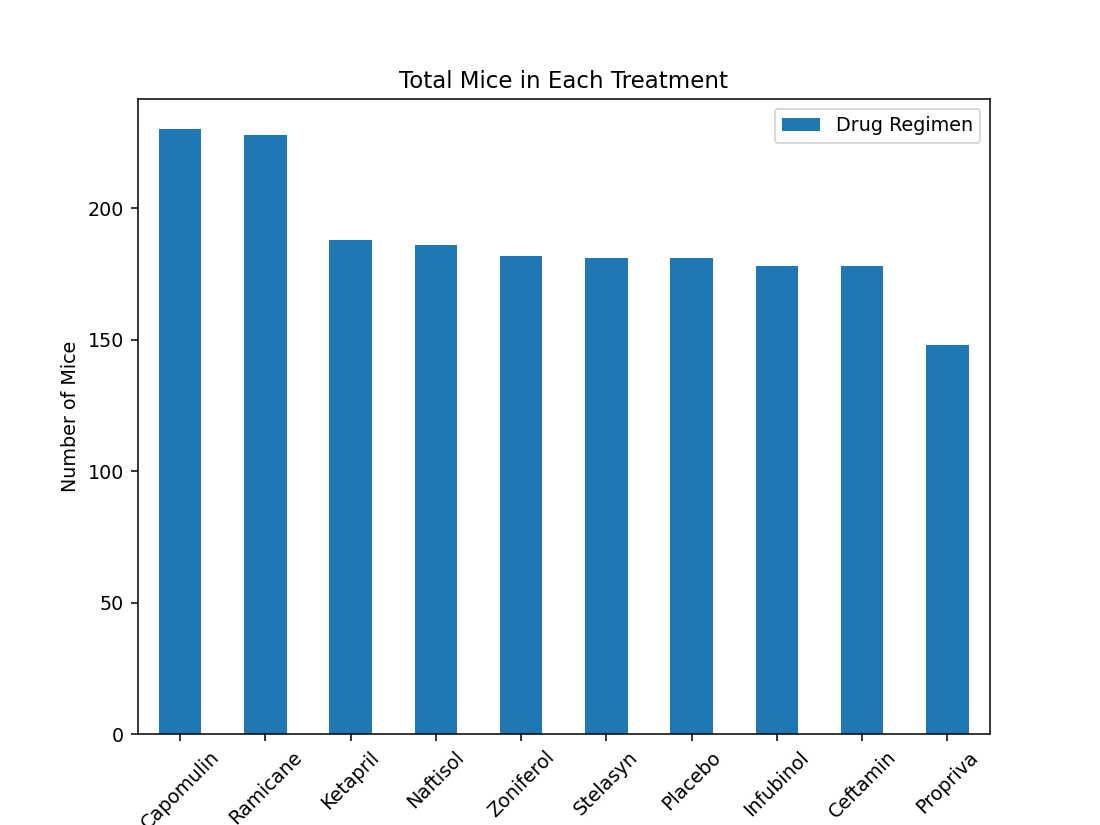

In [12]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.
bpcmousend_rpt_df = cmousend_rpt_df['Drug Regimen'].value_counts()
treat_ct = cmousend_rpt_df['Drug Regimen'].nunique()
y_treat_ct = len(cmousend_rpt_df.groupby(['Drug Regimen']))
x_axis = np.arange(0,treat_ct,1)

bpcmousend_rpt_df.plot(kind='bar',x=x_axis, y=y_treat_ct, rot=45, figsize=(8,6),
                           title='Total Mice in Each Treatment',
                           ylabel='Number of Mice',xlabel='Drug Regimen')
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


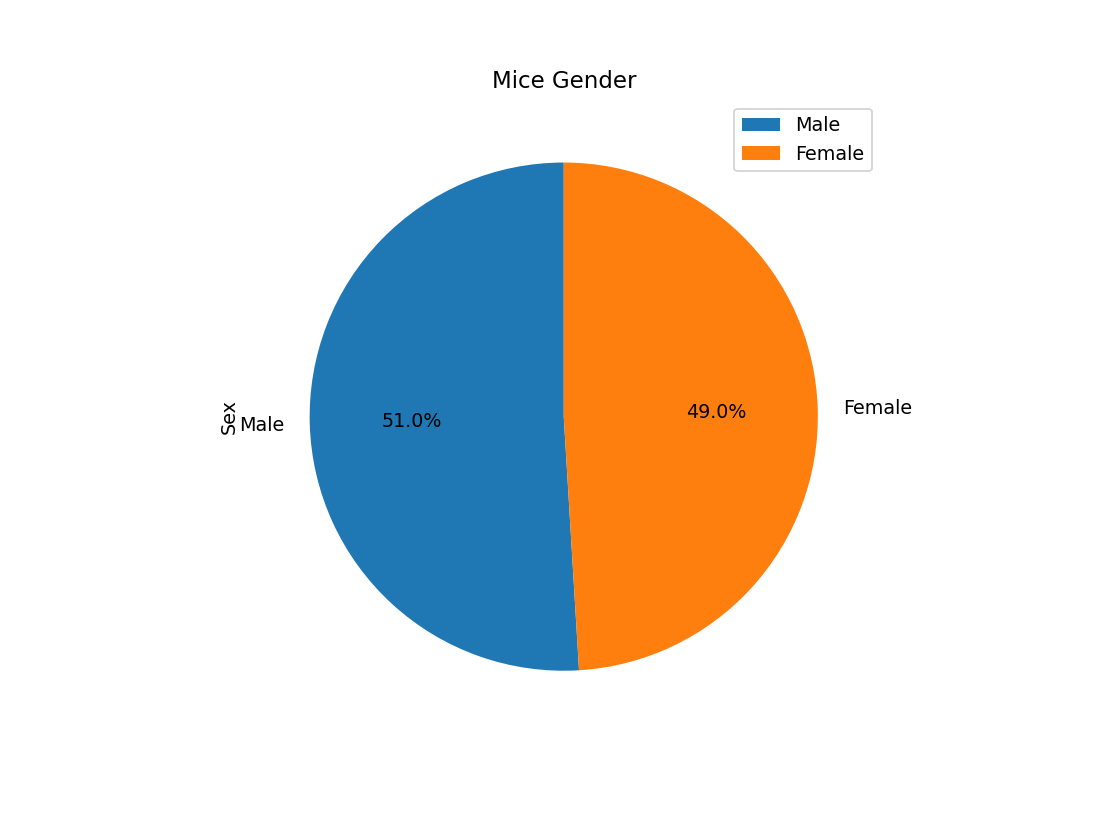

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
pie_cmouse_df = cmousend_rpt_df['Sex'].value_counts()

pie_cmouse_df.plot(kind = 'pie', figsize=(8, 6), startangle=90, autopct='%1.1f%%',
                  title='Mice Gender')

plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


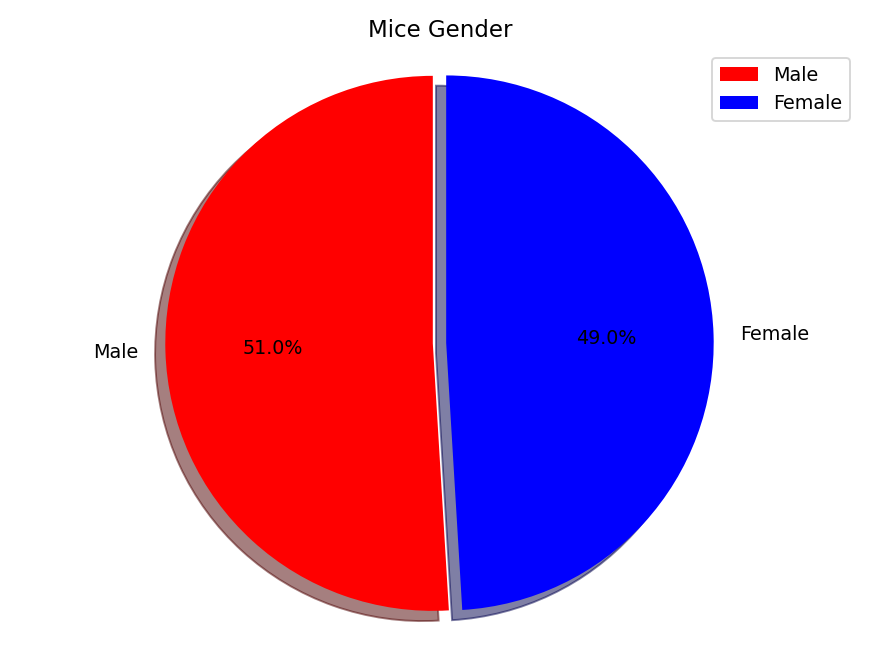

In [14]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
labels = cmousend_rpt_df['Sex'].unique()
sizes = cmousend_rpt_df['Sex'].value_counts()
colors = ['red','blue']
explode = [.05,0]
plt.pie(sizes, labels=labels ,colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90, explode=explode)
plt.legend(loc='best')
plt.title('Mice Gender')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
calfmicer = cmousend_rpt_df[['Mouse ID','Timepoint']]
calfmicer.set_index('Mouse ID', inplace=True)
mg_micers = calfmicer.max(level='Mouse ID')
mg_micers.reset_index(inplace=True)

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
ltp_tumvol = pd.merge(mg_micers,cmousend_rpt_df, how='left', on=['Mouse ID','Timepoint'])
cric_ltp_tumvol = ltp_tumvol.loc[(ltp_tumvol['Drug Regimen'] == 'Capomulin') |
                                (ltp_tumvol['Drug Regimen'] == 'Ceftamin') |
                                (ltp_tumvol['Drug Regimen'] == 'Infubinol') |
                                (ltp_tumvol['Drug Regimen'] == 'Ramicane')]

cric_ltp_tumvol.sort_values('Drug Regimen')

,Mouse ID,Timepoint,Drug Regimen,Sex,Age_months,Weight (g),Tumor Volume (mm3),Metastatic Sites
32,j246,35,Capomulin,Female,21,21,38.75,1
36,v923,45,Capomulin,Female,19,21,40.66,2
35,w150,10,Capomulin,Male,23,23,39.95,0
34,j119,45,Capomulin,Female,7,23,38.13,1
39,l509,45,Capomulin,Male,17,21,41.48,3
...,...,...,...,...,...,...,...,...
46,r921,30,Ramicane,Female,5,25,43.42,1
47,w678,5,Ramicane,Female,5,24,43.17,0
48,y449,15,Ramicane,Male,19,24,44.18,0
23,r811,45,Ramicane,Male,9,19,37.23,1


In [14]:
# Put treatments into a list for for loop (and later for plot labels)
treatment_lst = ['Capomulin', 'Ramicane', 'Infubinol','Ceftamin']

# Create empty list to fill with tumor vol data (for plotting)
tumor_vol_data = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    # Locate the rows which contain mice on each drug and get the tumor volumes

for drug in treatment_lst:
    data_for_tumor_vol = cric_ltp_tumvol.loc[cric_ltp_tumvol['Drug Regimen']== drug, ('Tumor Volume (mm3)')]

    # add subset
    tumor_vol_data.append(data_for_tumor_vol)

    # Determine outliers using upper and lower bounds
    quant_tumorvol = data_for_tumor_vol.quantile([0.25,0.50,0.75])
    lquant_tumorvol = quant_tumorvol[0.25] 
    uquant_tumorvol = quant_tumorvol[0.75]

    iqr_tumorvol = uquant_tumorvol - lquant_tumorvol

    lbound = lquant_tumorvol - (1.5 * iqr_tumorvol)
    ubound = uquant_tumorvol + (1.5 * iqr_tumorvol)
    
    tumor_outliers = data_for_tumor_vol.loc[(data_for_tumor_vol < lbound) | (data_for_tumor_vol > ubound)]
    
    if tumor_outliers.sum() == 0:
        print(f"{drug} has no potential outliers.")
    else:
        print(f"{drug} potential outliers: {tumor_outliers}")

Capomulin has no potential outliers.
Ramicane has no potential outliers.
Infubinol potential outliers: 74   36.32
Name: Tumor Volume (mm3), dtype: float64
Ceftamin has no potential outliers.


<IPython.core.display.Javascript object>


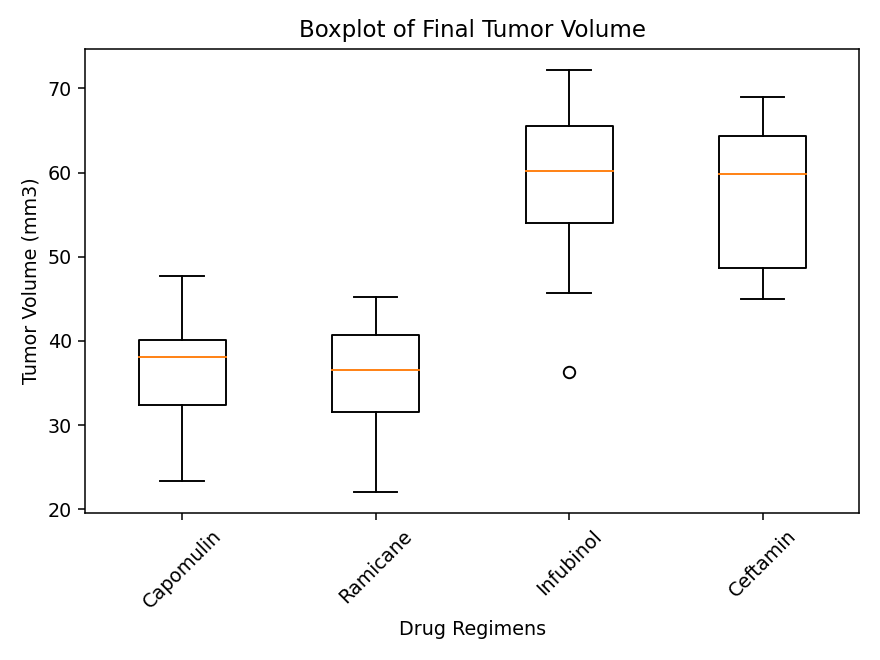

In [15]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
plt.boxplot(tumor_vol_data, labels=treatment_lst)
plt.xticks(rotation=45)
plt.title('Boxplot of Final Tumor Volume')
plt.xlabel('Drug Regimens')
plt.ylabel('Tumor Volume (mm3)')
plt.tight_layout()
plt.show()

## Line and Scatter Plots

<IPython.core.display.Javascript object>


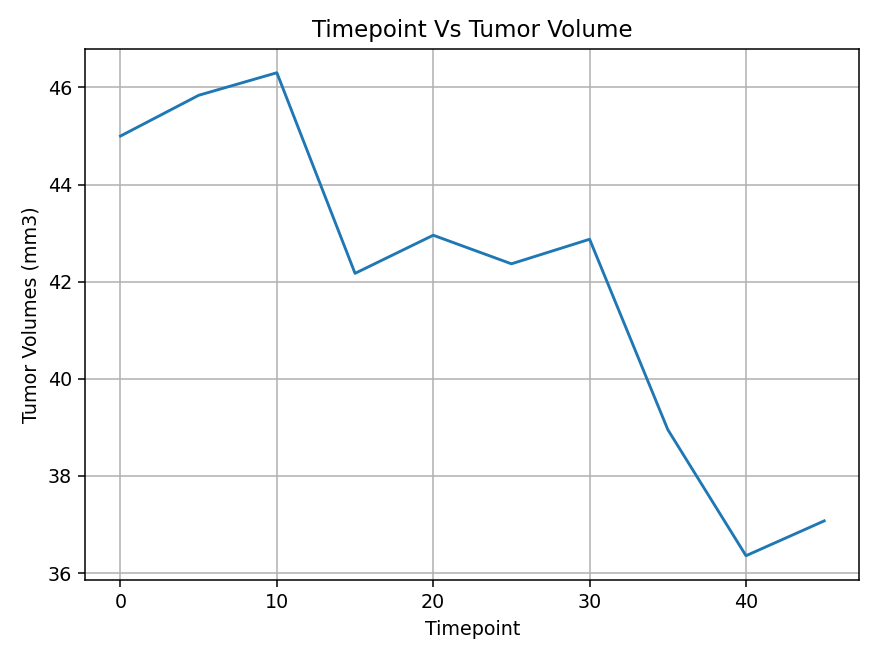

In [16]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
capomulin_mice = cmousend_rpt_df.loc[cmousend_rpt_df['Drug Regimen']=='Capomulin']

mouse_g288 = capomulin_mice.loc[capomulin_mice['Mouse ID'] == 'g288']

# # Create the X and Y axis lists

plt.plot(mouse_g288['Timepoint'],mouse_g288['Tumor Volume (mm3)'])

plt.title("Timepoint Vs Tumor Volume")
plt.xlabel("Timepoint")
plt.ylabel("Tumor Volumes (mm3)")

# plt.legend(handles=[time_point, tumor_volume], loc="best")

plt.grid()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


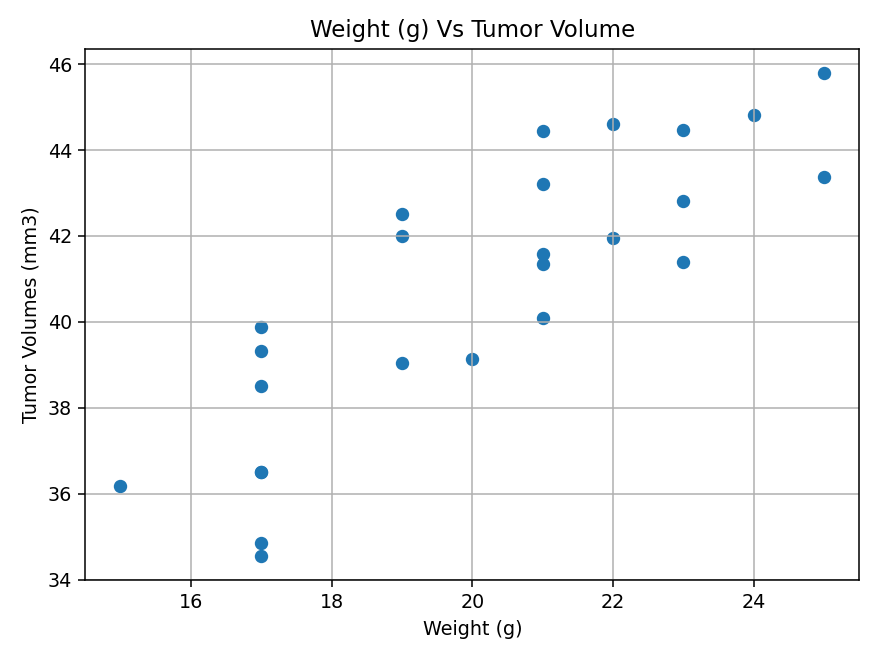

In [17]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimenc
capomulin_mice = cmousend_rpt_df.loc[cmousend_rpt_df['Drug Regimen']=='Capomulin']

avg_mouse = capomulin_mice.groupby(['Mouse ID']).mean()

plt.scatter(avg_mouse['Weight (g)'],avg_mouse['Tumor Volume (mm3)'])

plt.title("Weight (g) Vs Tumor Volume")
plt.xlabel("Weight (g)")
plt.ylabel("Tumor Volumes (mm3)")


plt.grid()
plt.tight_layout()
plt.show()

## Correlation and Regression

<IPython.core.display.Javascript object>


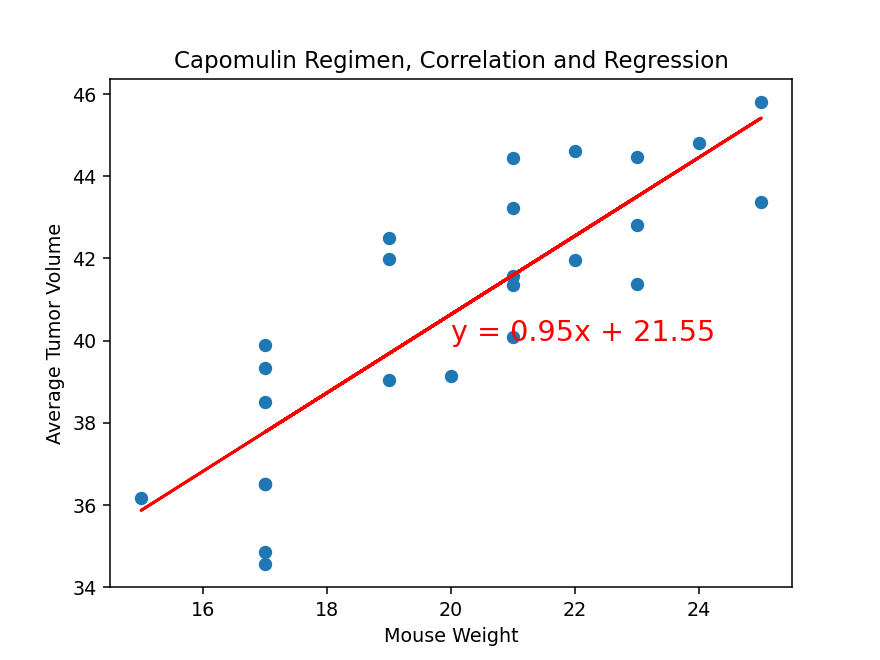

The correlatoin between both factors is 0.84
(0.8419363424694717, 1.322572243471279e-07)


In [18]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

capomulin_mice = cmousend_rpt_df.loc[cmousend_rpt_df['Drug Regimen']=='Capomulin']

avg_mouse = capomulin_mice.groupby(['Mouse ID']).mean()

x_values_wgt = avg_mouse['Weight (g)']
y_values_tvol = avg_mouse['Tumor Volume (mm3)']

# Linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values_wgt,y_values_tvol)
regress_values = (x_values_wgt * slope) + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values_wgt,y_values_tvol)
plt.plot(x_values_wgt,regress_values,"r-")
plt.annotate(line_eq,(20,40), fontsize=15, color='red')
plt.title('Capomulin Regimen, Correlation and Regression')
plt.xlabel('Mouse Weight')
plt.ylabel('Average Tumor Volume')
plt.show()

capomulin_correlation = st.pearsonr(x_values_wgt, y_values_tvol)
print(f"The correlatoin between both factors is {round(capomulin_correlation[0],2)}")
print(capomulin_correlation)